In [92]:
# TODO: CTCF?

Populating the interactive namespace from numpy and matplotlib
Removed 57 bins above 167.19790236182288
Could not find windows/GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH+chipulate-1kb.peak.numcopies1.counts
Could not find windows/GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH+chipulate-1kb.peak.numcopies5.counts
bams/GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH+chipulate-numcopies10000.flagged.bam
bams/GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH+chipulate-numcopies10000.flagged.bam 301879
bams/GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH+ischip-HighBG-numcopies10000.flagged.bam
bams/GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH+ischip-HighBG-numcopies10000.flagged.bam 247536
bams/GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH+ischip-numcopies10000.flagged.bam
bams/GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH+ischip-numcopies10000.flagged.bam 277886
bams/GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH-numcopies10000.flagged.bam
bams/GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH-numcopies10000.flagged.bam 264677
/storage/mgymrek/chipmunk_roun

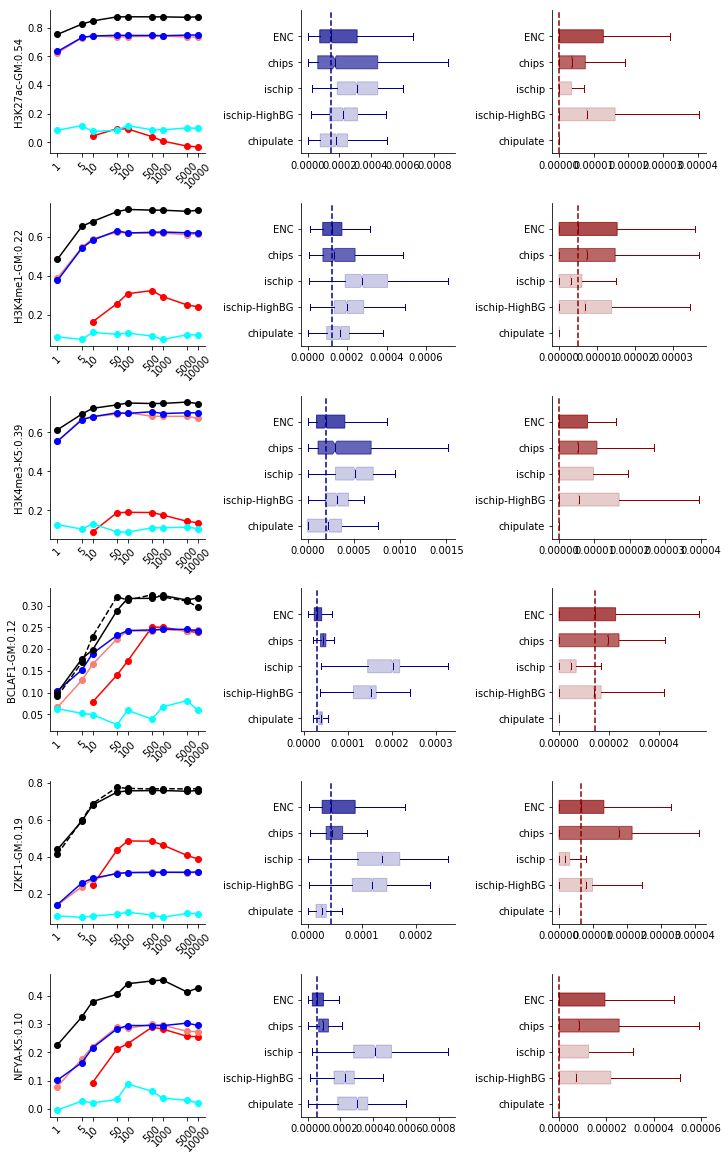

In [105]:
%pylab inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pandas as pd
import numpy as np
import scipy.stats
import subprocess
import json

SCATTERNUM = 5000
METHODS = ["chipulate","ischip-HighBG", "ischip","chips","ischip-pcr10"]

NUMCOPIES = np.array([1, 5, 10, 50, 100, 500, 1000, 5000, 10000])

PREFIXES = {"chips": "", "chipulate": "+chipulate", "ischip": "+ischip", "ischip-pcr10": "+ischip-pcr10",
           "ischip-HighBG":"+ischip-HighBG"}
COLORS = {"chips": "black", "chipulate": "red", "ischip": "blue","ischip-pcr10": "cyan", "ischip-HighBG": "salmon"}

HMWINDOW = 1
TFWINDOW = 1

DATASETS = {
    "BCLAF1-GM": {
        "OUTPREFIX": "GM12878_BCLAF1_ENCFF671NSO_ENCFF222GJV",
        "WINDOWSIZE": TFWINDOW,
        "paired": True
    },
    "H3K27ac-GM": {
        "OUTPREFIX": "GM12878_H3K27ac_ENCFF097SQI_ENCFF465WTH",
        "WINDOWSIZE": HMWINDOW,
        "paired": False
    },
    "H3K4me1-GM": {
        "OUTPREFIX": "GM12878_H3K4me1_ENCFF252ZII_ENCFF966LMJ",
        "WINDOWSIZE": HMWINDOW,
        "paired": False
    },
    "H3K4me3-K5": {
        "OUTPREFIX": "K562_H3K4me3_ENCFF681JQI_ENCFF127XXD",
        "WINDOWSIZE": HMWINDOW,
        "paired": False
    },
    "IZKF1-GM": {
        "OUTPREFIX": "GM12878_IKZF1_ENCFF216YZE_ENCFF795PEX",
        "WINDOWSIZE": TFWINDOW,
        "paired": True
    },
    "NFYA-K5": {
        "OUTPREFIX": "K562_NFYA_ENCFF000YUR_ENCFF003WYE",
        "WINDOWSIZE": TFWINDOW,
        "paired": False
    }
}

def LoadModel(outprefix):
    return json.load(open(outprefix+".json", "r"))
    
def PlotBoxes(boxdata, encdata, color, title, xlabels, fname=None, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)    
        ax.set_title(title)
    boxdict = ax.boxplot(boxdata+[encdata], positions=range(0, len(peakdata)), notch=True, patch_artist=True,
        boxprops=dict(facecolor=color, color=color),
        capprops=dict(color=color),
        whiskerprops=dict(color=color),
        flierprops=dict(color=color, markeredgecolor=color),
        medianprops=dict(color=color), vert=False, sym="")
    ax.axvline(x=np.median(encdata), color=color, linestyle="dashed")

    counter = 0
    for b in boxdict["boxes"]:
        if counter >= len(boxdata):
            b.set_alpha(0.7)
        else:
            b.set_alpha(0.2)
        if counter == (len(boxdata)-1):
            b.set_alpha(0.6)
        b.set_edgecolor(color)
        counter += 1

    ax.set_ylim(bottom=-0.5, top=len(peakdata))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticks([item for item in range(len(peakdata))])
    ax.set_yticklabels(xlabels)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if fname is not None and ax is None:
        fig.savefig(fname)

def GetNumReads(OUTPREFIX, method, nc):
    if method == "encode":
        bamfile = "/storage/mgymrek/chipmunk_round2/encode/%s/%s.flagged.bam"%(OUTPREFIX, OUTPREFIX)
    else:
        modifier = PREFIXES[method]
        bamfile = "bams/%s-numcopies%s.flagged.bam"%(OUTPREFIX+modifier, nc)
    print(bamfile)
    cmd = "samtools view %s chr22 | wc -l"%bamfile
    result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
    numreads = int(result.stdout)
    print("%s %s"%(bamfile, numreads))
    return numreads

def TransformCounts(countdata, numreads):
    # return np.log10((countdata+1)/numreads)
    return countdata/numreads

def RmOutliers(peakcounts):
    rmbin = []
    mean = np.mean(peakcounts)
    std = np.sqrt(np.var(peakcounts))
    thresh = mean+3*std
    for i in range(len(peakcounts)):
        if peakcounts[i]>(thresh):
            rmbin.append(True)
        else: rmbin.append(False)
    print("Removed %s bins above %s"%(sum(rmbin), thresh))
    return rmbin
    
def LoadData(ds, rmoutliers=False):
    OUTPREFIX=DATASETS[ds]["OUTPREFIX"]
    WINDOWSIZE=DATASETS[ds]["WINDOWSIZE"]
    
    # Load Encode data for comparison
    peak = pd.read_csv("windows/%s-%skb.peak.encode.counts"%(OUTPREFIX, WINDOWSIZE),
                             sep="\t",
                             names=["chrom","start","end","encode"])
    nopeak = pd.read_csv("windows/%s-%skb.nopeak.encode.counts"%(OUTPREFIX, WINDOWSIZE),
                             sep="\t",
                             names=["chrom","start","end","encode"])
    
    if rmoutliers:
        # Set outlier encode peaks to None
        peak["rmbin"] = RmOutliers(peak["encode"])
        
    # Get numcopies vs. r2, numcopies vs. time. one for each method
    corrs = {}
    times = {}
    for method in METHODS:
        corrs_ = []
        times_ = []
        modifier = PREFIXES[method]
        for nc in NUMCOPIES:
            try:
                dfp = pd.read_csv("windows/%s-%skb.peak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc), sep="\t", names=["chrom","start","end",nc])
                dfnp = pd.read_csv("windows/%s-%skb.nopeak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc), sep="\t", names=["chrom","start","end",nc])
                peak["%s_%s"%(method,nc)] = dfp[nc]
                nopeak["%s_%s"%(method,nc)] = dfnp[nc]
                xx = peak[~peak["rmbin"]]
                corrs_.append(scipy.stats.pearsonr(np.log10(xx["encode"]+1), np.log10(xx["%s_%s"%(method,nc)]+1))[0])
            except:
                corrs_.append(None)
                print("Could not find windows/%s-%skb.peak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc))
            try:
                metrics = pd.read_csv("metrics/%s-numcopies%s.sim_metrics"%(OUTPREFIX+modifier, nc), sep="\t")
                times_.append(metrics["s"])
            except:
                times_.append(None)
        corrs[method] = corrs_
        times[method] = times_
    
    # If paired, add that
    if DATASETS[ds]["paired"]:
        corrs_ = []
        times_ = []
        modifier = "_paired"
        for nc in NUMCOPIES:
            try:
                dfp = pd.read_csv("windows/%s-%skb.peak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc), sep="\t", names=["chrom","start","end",nc])
                dfnp = pd.read_csv("windows/%s-%skb.nopeak.numcopies%s.counts"%(OUTPREFIX+modifier, WINDOWSIZE, nc), sep="\t", names=["chrom","start","end",nc])
                peak["%s_%s"%(method,nc)] = dfp[nc]
                nopeak["%s_%s"%(method,nc)] = dfnp[nc]
                xx = peak[~peak["rmbin"]]
                corrs_.append(scipy.stats.pearsonr(np.log10(xx["encode"]+1), np.log10(xx["%s_%s"%(method,nc)]+1))[0])
            except:
                corrs_.append(None)
            try:
                metrics = pd.read_csv("metrics/%s-numcopies%s.sim_metrics"%(OUTPREFIX+modifier, nc), sep="\t")
                times_.append(metrics["s"])
            except:
                times_.append(None)
        corrs[method+modifier] = corrs_
        times[method+modifier] = times_
    return peak, nopeak, corrs, times

def PlotEncCorr(corrs, numcopies, ds, fname=None, ax=None):
    if ax is None:
        fig = plt.figure()
        fig.set_size_inches((5, 2))
        ax = fig.add_subplot(111)
    for method in METHODS:
        ax.plot(np.log10(numcopies), corrs[method], color=COLORS[method], marker="o", label=method)
    if DATASETS[ds.split(":")[0]]["paired"]:
        ax.plot(np.log10(numcopies), corrs[method+"_paired"], color=COLORS["chips"], 
                linestyle="dashed", marker="o", label="chips-paired")
    ax.set_xticks(np.log10(numcopies))
    ax.set_xticklabels(numcopies, rotation=45)
    #ax.set_ylim(bottom=0, top=1)
    #ax.set_xlabel("# Simulation rounds", size=12)
    #ax.set_ylabel("R(ENCODE, sim)", size=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylabel(ds)
    #ax.legend(loc="upper left")
    if fname is None and ax is None: fig.savefig(OUTPREFIX+"-numcopies.pdf")  

def PlotTime(times, numcopies, fname=None, ax=None):
    if ax is None:
        fig = plt.figure()
        fig.set_size_inches((5, 2))
        ax = fig.add_subplot(111)
    for method in METHODS:
        #print(list(times[method]))
        ax.plot(np.log10(NUMCOPIES), times[method], COLORS[method], marker="o")
    if DATASETS[ds]["paired"]:
        ax.plot(np.log10(NUMCOPIES), times[method+"_paired"], color=COLORS["chips"], linestyle="dashed", marker="o")
    ax.set_xticks(np.log10(NUMCOPIES))
    ax.set_xticklabels(NUMCOPIES, rotation=45)
    ax.set_xlabel("# Simulation rounds", size=12)
    ax.set_ylabel("time (s)", size=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(ds)
    if fname is None and ax is None: fig.savefig(OUTPREFIX+"-time.pdf")

def PlotScatters(peak, nopeak, scatternum):
    for method in METHODS:
        if "pcr" in method: continue
        if "%s_%s"%(method,SCATTERNUM) not in peak.columns: continue
        
        # Get scatter plot of counts
        modifier = PREFIXES[method]
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(np.log10(peak["encode"]+1), np.log10(peak["%s_%s"%(method,scatternum)]+1), color="darkblue", s=5, label="Peak regions")
        ax.scatter(np.log10(nopeak["encode"]+1), np.log10(nopeak["%s_%s"%(method,scatternum)]+1), color="darkred", s=5, label="Background")
        print(scipy.stats.pearsonr(np.log10(peak["encode"]+1), np.log10(peak["%s_%s"%(method,scatternum)]+1)))
        print(peak["%s_%s"%(method,scatternum)].shape)
        #ax.set_xlim(left=-0.1, right=xmax)
        #ax.set_ylim(bottom=-0.1, top=ymax)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel("log10(ENCODE reads)", size=12)
        ax.set_ylabel("log10(sim reads)", size=12);
        ax.legend(loc="upper left");
        ax.set_title(ds+OUTPREFIX+modifier)
        fig.savefig(OUTPREFIX+modifier+"-scatter.pdf")

fig1, f1_axes = plt.subplots(ncols=3, nrows=len(DATASETS.keys()), constrained_layout=True)
fig1.set_size_inches((10, 16))

DATASET_LIST = ['H3K27ac-GM','H3K4me1-GM', 'H3K4me3-K5',  'BCLAF1-GM', 'IZKF1-GM', 'NFYA-K5'] #'CTCF-GM',
rownum = 0
for ds in DATASET_LIST: #DATASETS.keys():
    OUTPREFIX=DATASETS[ds]["OUTPREFIX"]
    WINDOWSIZE=DATASETS[ds]["WINDOWSIZE"]
    model = LoadModel(OUTPREFIX)

    peak, nopeak, corrs, times = LoadData(ds, rmoutliers=True)
  
    # Plot numcopies vs. pearson R. One line per method
    PlotEncCorr(corrs, NUMCOPIES, ds+":"+"%0.2f"%(model["pulldown"]["s"]), ax=f1_axes[rownum, 0])

    # Numcopies vs. time
    #PlotTime(times, NUMCOPIES)

    # Get scatter plots of counts for each method
    #PlotScatters(peak[~peak["rmbin"]], nopeak, SCATTERNUM)
    
    # Get box plots of read counts in/out of peaks
    # Normalize by num. reads mapped to chr22
    
    # First load data
    peakdata = []
    nopeakdata = []
    xlabels = []
    for method in METHODS:
        if "pcr" in method: continue
        if "%s_%s"%(method,SCATTERNUM) not in peak.columns:
            peakdata.append([])
            nopeakdata.append([])
        else:
            numreads = GetNumReads(OUTPREFIX, method, nc)
            peakdata.append(TransformCounts(peak["%s_%s"%(method,SCATTERNUM)], numreads))
            nopeakdata.append(TransformCounts(nopeak["%s_%s"%(method,SCATTERNUM)], numreads))
        xlabels.append(method)
    numencreads = GetNumReads(OUTPREFIX, "encode", None)
    peakdata.append(TransformCounts(peak["encode"], numencreads))
    nopeakdata.append(TransformCounts(nopeak["encode"], numencreads))
    xlabels.append("ENC")

    PlotBoxes(peakdata[:-1], peakdata[-1], "darkblue", ds, xlabels, ax=f1_axes[rownum, 1])
    PlotBoxes(nopeakdata[:-1], nopeakdata[-1], "darkred", ds, xlabels, ax=f1_axes[rownum, 2])
    
    rownum += 1
fig1.savefig("simulation-method-compare-COMBINED.pdf")